In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! pip install pgmpy

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
import numpy as np

import common

In [5]:
date_set_path = "../temp_sets_100/"

## icustays

### Read samples

In [6]:
icustays_df = common.read_csv_no_rowid(date_set_path+"icustays.csv")

### Data preproces

In [7]:
# Drop useless colums
icustays_df.drop(['los'], axis=1, inplace=True)

#### Deal with null values

In [8]:
# Check null value in table
common.nan_count(icustays_df)

Total columns: 10
Total rows: 124
--------------
subject_id        0
hadm_id           0
icustay_id        0
dbsource          0
first_careunit    0
last_careunit     0
first_wardid      0
last_wardid       0
intime            0
outtime           0
dtype: int64


#### Set the column types

In [9]:
icustays_df.dtypes

subject_id         int64
hadm_id            int64
icustay_id         int64
dbsource          object
first_careunit    object
last_careunit     object
first_wardid       int64
last_wardid        int64
intime            object
outtime           object
dtype: object

In [10]:
# Transfer some date type
icustays_df['intime'] = pd.to_datetime(icustays_df['intime'])
icustays_df['outtime'] = pd.to_datetime(icustays_df['outtime'])

In [11]:
icustays_df.dtypes

subject_id                 int64
hadm_id                    int64
icustay_id                 int64
dbsource                  object
first_careunit            object
last_careunit             object
first_wardid               int64
last_wardid                int64
intime            datetime64[ns]
outtime           datetime64[ns]
dtype: object

#### Deal with some special value

In [12]:
icustays_df.head()

,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime
0,569,116412,271533,carevue,CCU,CCU,7,7,2105-02-21 13:33:20,2105-02-23 17:46:48
1,26282,123094,224604,carevue,SICU,SICU,57,57,2152-03-31 23:27:42,2152-04-01 21:11:12
2,1762,126479,266937,carevue,NICU,NICU,56,56,2120-03-19 10:03:24,2120-03-27 16:11:07
3,14481,129421,224797,carevue,SICU,SICU,14,14,2116-05-08 21:43:00,2116-05-09 13:10:00
4,21470,107803,286277,carevue,NICU,NICU,26,26,2195-05-20 10:32:00,2195-05-20 15:47:00


---

##  Build Network

In [13]:
from sdv.tabular import CTGAN
from sdv.constraints import FixedCombinations
from sdv.constraints import create_custom_constraint

In [14]:
icustays_df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'first_careunit',
       'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

### Set constraint

In [15]:
(icustays_df['outtime'] - icustays_df['intime']).apply(lambda x: x.days).min()

0

In [16]:
def time_is_valid(column_names, data):
    intime_outtime = ((data['outtime'] - data['intime']).apply(lambda x: 0 <= x.days  <= 365))
    
    return intime_outtime

In [17]:
def time_trasform(column_names, data):
    # print(data.loc[:, ['dod', 'dod_hosp', 'dod_ssn']])
    return data

def time_reverse_transform(column_names, transformed_data):
    transformed_data['intime'] = pd.to_datetime(transformed_data['intime'])
    transformed_data['outtime'] = pd.to_datetime(transformed_data['outtime'])

    return transformed_data

In [18]:
TimeProcess = create_custom_constraint(
    is_valid_fn=time_is_valid,
    transform_fn=time_trasform,
    reverse_transform_fn=time_reverse_transform
)

In [19]:
time_constraint = TimeProcess(
    column_names=['intime', 'outtime']
)

In [20]:
constrains = [time_constraint]

### Build model

In [21]:
model = CTGAN(
    # constraints=constrains, 
    # generator_lr=0.0005,
    batch_size=100,
    cuda=True, 
    verbose=True, 
    epochs=50)

In [22]:
len(icustays_df)

124

In [23]:
train_data = icustays_df
model.fit(train_data)

Epoch 1, Loss G:  1.4511,Loss D: -0.0030
Epoch 2, Loss G:  1.3786,Loss D: -0.0093
Epoch 3, Loss G:  1.4435,Loss D:  0.0100
Epoch 4, Loss G:  1.3366,Loss D: -0.0125
Epoch 5, Loss G:  1.4390,Loss D:  0.0429
Epoch 6, Loss G:  1.5456,Loss D:  0.0031
Epoch 7, Loss G:  1.4775,Loss D:  0.0306
Epoch 8, Loss G:  1.4216,Loss D: -0.0421
Epoch 9, Loss G:  1.3093,Loss D: -0.1282
Epoch 10, Loss G:  1.4577,Loss D: -0.1666
Epoch 11, Loss G:  1.4631,Loss D: -0.0707
Epoch 12, Loss G:  1.3093,Loss D: -0.0856
Epoch 13, Loss G:  1.3373,Loss D: -0.1300
Epoch 14, Loss G:  1.3277,Loss D: -0.0458
Epoch 15, Loss G:  1.4437,Loss D:  0.0191
Epoch 16, Loss G:  1.4331,Loss D: -0.0582
Epoch 17, Loss G:  1.3265,Loss D: -0.0933
Epoch 18, Loss G:  1.3486,Loss D:  0.0010
Epoch 19, Loss G:  1.1094,Loss D: -0.1541
Epoch 20, Loss G:  1.1383,Loss D: -0.0760
Epoch 21, Loss G:  1.1809,Loss D: -0.0510
Epoch 22, Loss G:  1.1831,Loss D: -0.0639
Epoch 23, Loss G:  1.2642,Loss D: -0.1950
Epoch 24, Loss G:  1.1476,Loss D: -0.1766
E

In [24]:
import cloudpickle

with open(date_set_path + "100_models/" + "icustays_model.pkl", 'wb') as f:
    cloudpickle.dump(model, f)

In [25]:
# model.save(date_set_path + "100_models/" + "icustays_model.pkl")

In [26]:
sample = model.sample(100)

In [27]:
sample.head()

,subject_id,hadm_id,icustay_id,dbsource,first_careunit,last_careunit,first_wardid,last_wardid,intime,outtime
0,59999,181470,283907,carevue,SICU,CSRU,7,7,2106-11-06 11:07:59.069455360,2139-11-09 08:17:38.956508160
1,41643,100223,207367,metavision,CSRU,CSRU,7,12,2095-09-13 07:59:53.891051520,2100-11-27 19:12:17.320804352
2,11284,142332,228735,carevue,NICU,CSRU,7,7,2102-12-28 20:21:19.410435072,2165-10-16 06:56:40.899204096
3,99503,159194,299407,metavision,SICU,NICU,7,7,2107-02-22 16:08:56.630075392,2208-03-15 23:02:09.386450944
4,99503,109790,265116,metavision,MICU,CCU,13,17,2105-01-21 17:23:14.514159616,2136-01-01 05:55:29.774772224


### Process the generated data

---

## Evaluate data

In [28]:
from sdv.evaluation import evaluate

In [29]:
train_data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'dbsource', 'first_careunit',
       'last_careunit', 'first_wardid', 'last_wardid', 'intime', 'outtime'],
      dtype='object')

In [30]:
evaluate(sample, train_data, metrics=['DiscreteKLDivergence'])

0.3103376251843734

In [31]:
evaluate(sample, train_data, metrics=['ContinuousKLDivergence'])

0.16480159070027522

In [32]:
sample['dbsource'].value_counts()

carevue       54
metavision    46
Name: dbsource, dtype: int64

<AxesSubplot:>

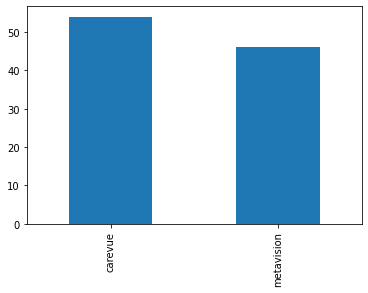

In [33]:
sample['dbsource'].value_counts().plot.bar()

In [34]:
train_data['dbsource'].value_counts()

carevue       72
metavision    52
Name: dbsource, dtype: int64

<AxesSubplot:>

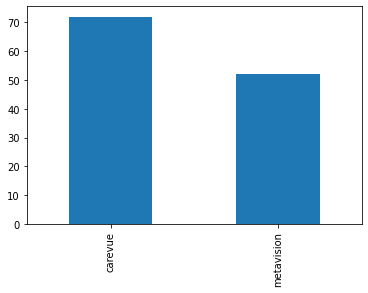

In [35]:
train_data['dbsource'].value_counts().plot.bar()